In [7]:
import numpy as np
import pandas as pd
import glob
import os
import gc
from itertools import combinations
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from keras.layers import Input, Dense
from keras.models import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import plot_model

for dirname, _, filenames in os.walk('/csv_files'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [8]:
dataset_csv_path = './csv_files/'
csv_files_pattern = '*.csv'
full_path = os.path.join(dataset_csv_path, csv_files_pattern)
csv_files = glob.glob(full_path)

df = pd.concat(map(pd.read_csv, csv_files), ignore_index=True)
df.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,54865,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,55054,109,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,55055,52,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,46236,34,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,54863,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [9]:
print("Columns in dataset are: ", df.columns)

Columns in dataset are:  Index([' Destination Port', ' Flow Duration', ' Total Fwd Packets',
       ' Total Backward Packets', 'Total Length of Fwd Packets',
       ' Total Length of Bwd Packets', ' Fwd Packet Length Max',
       ' Fwd Packet Length Min', ' Fwd Packet Length Mean',
       ' Fwd Packet Length Std', 'Bwd Packet Length Max',
       ' Bwd Packet Length Min', ' Bwd Packet Length Mean',
       ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s',
       ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min',
       'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max',
       ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std',
       ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Bwd PSH Flags',
       ' Fwd URG Flags', ' Bwd URG Flags', ' Fwd Header Length',
       ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s',
       ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean',
       ' Packet Length Std', ' P

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2830743 entries, 0 to 2830742
Data columns (total 79 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0    Destination Port             int64  
 1    Flow Duration                int64  
 2    Total Fwd Packets            int64  
 3    Total Backward Packets       int64  
 4   Total Length of Fwd Packets   int64  
 5    Total Length of Bwd Packets  int64  
 6    Fwd Packet Length Max        int64  
 7    Fwd Packet Length Min        int64  
 8    Fwd Packet Length Mean       float64
 9    Fwd Packet Length Std        float64
 10  Bwd Packet Length Max         int64  
 11   Bwd Packet Length Min        int64  
 12   Bwd Packet Length Mean       float64
 13   Bwd Packet Length Std        float64
 14  Flow Bytes/s                  float64
 15   Flow Packets/s               float64
 16   Flow IAT Mean                float64
 17   Flow IAT Std                 float64
 18   Flow IAT Max         

In [11]:
df.describe()

C:\Users\marck\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
C:\Users\marck\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,...,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06
mean,8.071483e+03,1.478566e+07,9.361160e+00,1.039377e+01,5.493024e+02,1.616264e+04,2.075999e+02,1.871366e+01,5.820194e+01,6.891013e+01,...,5.418218e+00,-2.741688e+03,8.155132e+04,4.113412e+04,1.531825e+05,5.829582e+04,8.316037e+06,5.038439e+05,8.695752e+06,7.920031e+06
std,1.828363e+04,3.365374e+07,7.496728e+02,9.973883e+02,9.993589e+03,2.263088e+06,7.171848e+02,6.033935e+01,1.860912e+02,2.811871e+02,...,6.364257e+02,1.084989e+06,6.485999e+05,3.933815e+05,1.025825e+06,5.770923e+05,2.363008e+07,4.602984e+06,2.436689e+07,2.336342e+07
min,0.000000e+00,-1.300000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,-5.368707e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,5.300000e+01,1.550000e+02,2.000000e+00,1.000000e+00,1.200000e+01,0.000000e+00,6.000000e+00,0.000000e+00,6.000000e+00,0.000000e+00,...,0.000000e+00,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,8.000000e+01,3.131600e+04,2.000000e+00,2.000000e+00,6.200000e+01,1.230000e+02,3.700000e+01,2.000000e+00,3.400000e+01,0.000000e+00,...,1.000000e+00,2.400000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,4.430000e+02,3.204828e+06,5.000000e+00,4.000000e+00,1.870000e+02,4.820000e+02,8.100000e+01,3.600000e+01,5.000000e+01,2.616295e+01,...,2.000000e+00,3.200000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,6.553500e+04,1.200000e+08,2.197590e+05,2.919220e+05,1.290000e+07,6.554530e+08,2.482000e+04,2.325000e+03,5.940857e+03,7.125597e+03,...,2.135570e+05,1.380000e+02,1.100000e+08,7.420000e+07,1.100000e+08,1.100000e+08,1.200000e+08,7.690000e+07,1.200000e+08,1.200000e+08


In [12]:
df[' Label'].nunique()

15

In [13]:
def data_cleaning(df):
    df.columns=df.columns.str.strip()
    print("Dataset Shape: ",df.shape)
    
    num = df._get_numeric_data()
    num[num < 0] = 0
    
    zero_variance_cols=[]
    for col in df.columns:
        if len(df[col].unique()) == 1:
            zero_variance_cols.append(col)
    df.drop(columns = zero_variance_cols, axis = 1, inplace = True)
    print("Zero Variance Columns: ", zero_variance_cols, "are dropped.")
    print("Shape after removing the zero variance columns: ", df.shape)
    
    df.replace([np.inf,-np.inf],np.nan,inplace=True)
    print(df.isna().any(axis = 1).sum(),"rows dropped")
    df.dropna(inplace = True)
    print("Shape after Removing NaN: ", df.shape)
    
    df.drop_duplicates(inplace=True)
    print("Shape after dropping duplicates: ", df.shape)
    
    column_pairs = [(i,j) for i,j in combinations(df,2) if df[i].equals(df[j])]
    ide_cols=[]
    for col_pair in column_pairs:
        ide_cols.append(col_pair[1])
    df.drop(columns=ide_cols,axis=1,inplace=True)
    print("Columns which have identical values: ",column_pairs," dropped!")
    print("Shape after removing identical value columns: ",df.shape)
    return df
df=data_cleaning(df)

Dataset Shape:  (2830743, 79)
Zero Variance Columns:  ['Bwd PSH Flags', 'Bwd URG Flags', 'Fwd Avg Bytes/Bulk', 'Fwd Avg Packets/Bulk', 'Fwd Avg Bulk Rate', 'Bwd Avg Bytes/Bulk', 'Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate'] are dropped.
Shape after removing the zero variance columns:  (2830743, 71)
2867 rows dropped
Shape after Removing NaN:  (2827876, 71)
Shape after dropping duplicates:  (2520798, 71)
Columns which have identical values:  [('Total Fwd Packets', 'Subflow Fwd Packets'), ('Total Backward Packets', 'Subflow Bwd Packets'), ('Fwd PSH Flags', 'SYN Flag Count'), ('Fwd URG Flags', 'CWE Flag Count'), ('Fwd Header Length', 'Fwd Header Length.1')]  dropped!
Shape after removing identical value columns:  (2520798, 66)


In [14]:
df['Label'].value_counts()

Label
BENIGN                        2095057
DoS Hulk                       172846
DDoS                           128014
PortScan                        90694
DoS GoldenEye                   10286
FTP-Patator                      5931
DoS slowloris                    5385
DoS Slowhttptest                 5228
SSH-Patator                      3219
Bot                              1948
Web Attack � Brute Force         1470
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name: count, dtype: int64

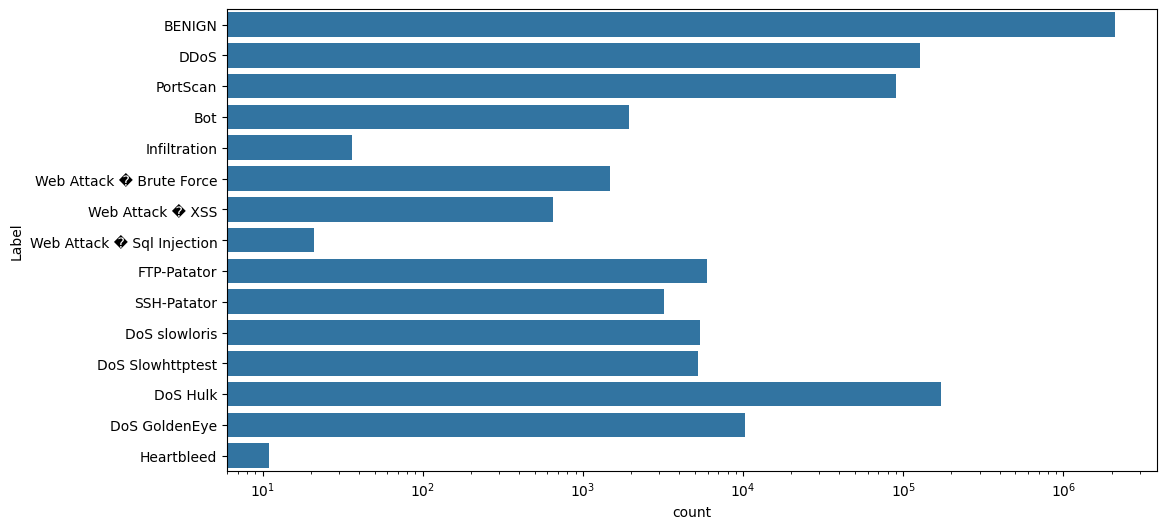

In [24]:
plt.figure(figsize=(12, 6))
plot = sns.countplot(data=df[df['Label'] != 'BENIGNE'], y='Label')
plt.xscale('log')
fig = plot.get_figure()
fig.savefig('img1.png')

C:\Users\marck\AppData\Local\Temp\ipykernel_1712\2223908736.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  subsample_df=df.groupby('Label').apply(pd.DataFrame.sample,frac=0.1).reset_index(drop=True)


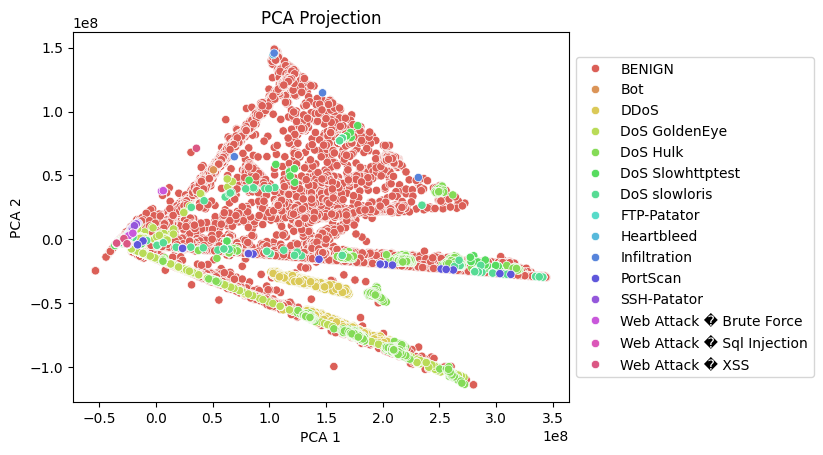

In [25]:
subsample_df=df.groupby('Label').apply(pd.DataFrame.sample,frac=0.1).reset_index(drop=True)
x=subsample_df.drop(['Label'],axis=1)
y=subsample_df['Label']

pca=PCA(n_components=2, random_state=0)
z=pca.fit_transform(x)

pca_df=pd.DataFrame()
pca_df['Label']=y
pca_df['PCA 1']=z[:,0]
pca_df['PCA 2']=z[:,1]

sns.scatterplot(data=pca_df,x='PCA 1',y='PCA 2',hue='Label',palette=sns.color_palette('hls',len(pca_df.Label.value_counts()))).set_title("PCA Projection")
plt.legend(loc='center left',bbox_to_anchor=(1,0.5))
plt.show()

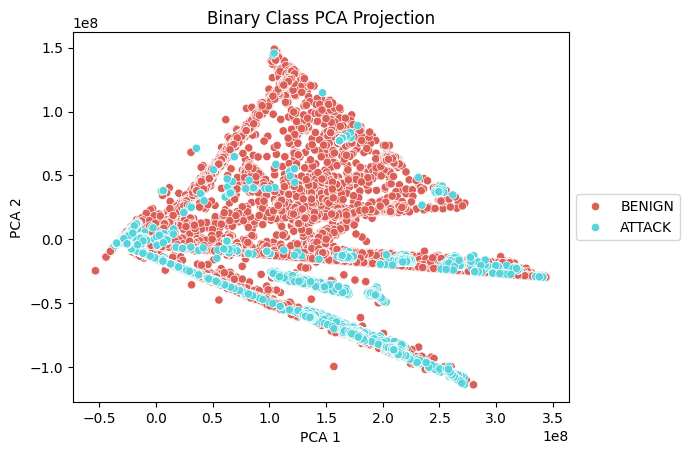

In [26]:
 pca_df.loc[pca_df.Label !='BENIGN','Label']='ATTACK'
 sns.scatterplot(data=pca_df,x='PCA 1',y='PCA 2',hue=pca_df.Label,palette=sns.color_palette('hls',2)).set_title("Binary Class PCA Projection")
 plt.legend(loc='center left',bbox_to_anchor=(1,0.5))
 plt.show()

In [27]:
df.columns=df.columns.str.strip().str.lower().str.replace(' ','_').str.replace('(','').str.replace(')','')
df.head()

,destination_port,flow_duration,total_fwd_packets,total_backward_packets,total_length_of_fwd_packets,total_length_of_bwd_packets,fwd_packet_length_max,fwd_packet_length_min,fwd_packet_length_mean,fwd_packet_length_std,...,min_seg_size_forward,active_mean,active_std,active_max,active_min,idle_mean,idle_std,idle_max,idle_min,label
0,54865,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,55054,109,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,55055,52,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,46236,34,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,54863,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [28]:
df['label'].value_counts()

label
BENIGN                        2095057
DoS Hulk                       172846
DDoS                           128014
PortScan                        90694
DoS GoldenEye                   10286
FTP-Patator                      5931
DoS slowloris                    5385
DoS Slowhttptest                 5228
SSH-Patator                      3219
Bot                              1948
Web Attack � Brute Force         1470
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name: count, dtype: int64

In [29]:
new_df=df.copy()

In [30]:
df.loc[df['label']!='BENIGN','label']='ATTACK'
df.head()

,destination_port,flow_duration,total_fwd_packets,total_backward_packets,total_length_of_fwd_packets,total_length_of_bwd_packets,fwd_packet_length_max,fwd_packet_length_min,fwd_packet_length_mean,fwd_packet_length_std,...,min_seg_size_forward,active_mean,active_std,active_max,active_min,idle_mean,idle_std,idle_max,idle_min,label
0,54865,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,55054,109,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,55055,52,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,46236,34,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,54863,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [31]:
df['label'].value_counts()

label
BENIGN    2095057
ATTACK     425741
Name: count, dtype: int64

In [32]:
new_df=df.copy()

In [33]:
df.loc[df['label']!='BENIGN','label']='ATTACK'
df.head()

,destination_port,flow_duration,total_fwd_packets,total_backward_packets,total_length_of_fwd_packets,total_length_of_bwd_packets,fwd_packet_length_max,fwd_packet_length_min,fwd_packet_length_mean,fwd_packet_length_std,...,min_seg_size_forward,active_mean,active_std,active_max,active_min,idle_mean,idle_std,idle_max,idle_min,label
0,54865,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,55054,109,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,55055,52,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,46236,34,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,54863,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [34]:
df.label.value_counts()

label
BENIGN    2095057
ATTACK     425741
Name: count, dtype: int64

<Axes: xlabel='label', ylabel='count'>

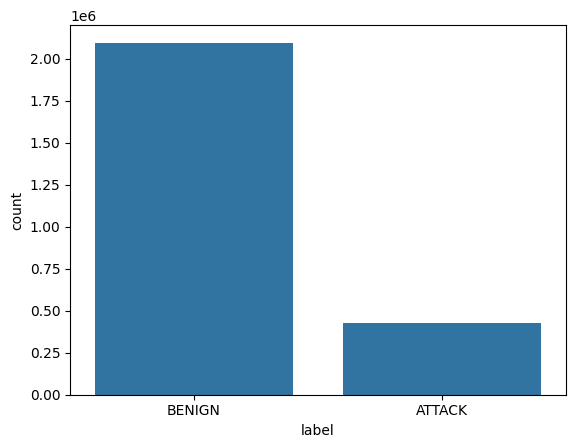

In [35]:
sns.countplot(data=df,x=df['label'])

In [36]:
size=len(df.loc[df.label=='ATTACK'])
print(size)
bal_df=df.groupby('label').apply(lambda x: x.sample(n=min(size,len(x))))

425741


C:\Users\marck\AppData\Local\Temp\ipykernel_1712\3892471950.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  bal_df=df.groupby('label').apply(lambda x: x.sample(n=min(size,len(x))))


<Axes: xlabel='label', ylabel='count'>

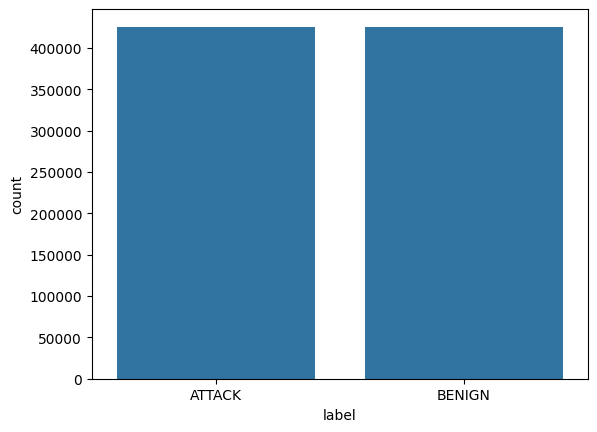

In [37]:
sns.countplot(data=bal_df,x='label')

In [38]:
bal_df.shape

(851482, 66)

In [39]:
gc.collect()

18751

In [40]:
bal_df.loc[bal_df['label']== 'ATTACK','label']=1
bal_df.loc[bal_df['label']=='BENIGN','label']=0

In [41]:
type(bal_df.label)

pandas.core.series.Series

In [42]:
X=bal_df.drop(columns='label')
y=bal_df['label'].astype('int')
X=MinMaxScaler().fit_transform(X)

In [43]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)
print(X_train.shape," ",X_test.shape)
print(y_train.shape," ",y_test.shape)

(681185, 65)   (170297, 65)
(681185,)   (170297,)


In [44]:
Xn=new_df.drop(columns='label')
Xn=MinMaxScaler().fit_transform(Xn)
yn=new_df['label']
yn=LabelEncoder().fit_transform(yn)
Xn_train,Xn_test,yn_train,yn_test=train_test_split(Xn,yn,test_size=0.2)

In [45]:
print(Xn_test.shape,Xn_train.shape)
print(yn_test.shape,yn_train.shape)

(504160, 65) (2016638, 65)
(504160,) (2016638,)


In [46]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)
print(X_train.shape," ",X_test.shape)
print(y_train.shape," ",y_test.shape)

(681185, 65)   (170297, 65)
(681185,)   (170297,)


In [47]:
input_data = Input(shape=(65,))
encoded = Dense(32, activation='relu')(input_data)
decoded = Dense(65, activation='sigmoid')(encoded)

autoencoder = Model(input_data, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['accuracy'])
plot_model(autoencoder, show_shapes=True)

encoder = Model(input_data, encoded)
encoded_input = Input(shape=(32,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(encoded_input, decoder_layer(encoded_input))

Epoch 1/20


15755/15755 [==============================] - 16s 988us/step - loss: 0.0022 - accuracy: 0.9115 - val_loss: 9.8536e-05 - val_accuracy: 0.9565
Epoch 2/20
15755/15755 [==============================] - 15s 945us/step - loss: 5.7927e-05 - accuracy: 0.9348 - val_loss: 7.6885e-05 - val_accuracy: 0.9564
Epoch 3/20
15755/15755 [==============================] - 15s 941us/step - loss: 4.0243e-05 - accuracy: 0.9340 - val_loss: 5.6177e-05 - val_accuracy: 0.9564
Epoch 4/20
15755/15755 [==============================] - 15s 937us/step - loss: 3.3608e-05 - accuracy: 0.9255 - val_loss: 5.2258e-05 - val_accuracy: 0.9419
Epoch 5/20
15755/15755 [==============================] - 15s 942us/step - loss: 3.1223e-05 - accuracy: 0.9279 - val_loss: 5.3479e-05 - val_accuracy: 0.9534
Epoch 6/20
15755/15755 [==============================] - 15s 939us/step - loss: 2.9804e-05 - accuracy: 0.9292 - val_loss: 4.9816e-05 - val_accuracy: 0.9500
Epoch 7/20
15755/15755 [==============================] - 15

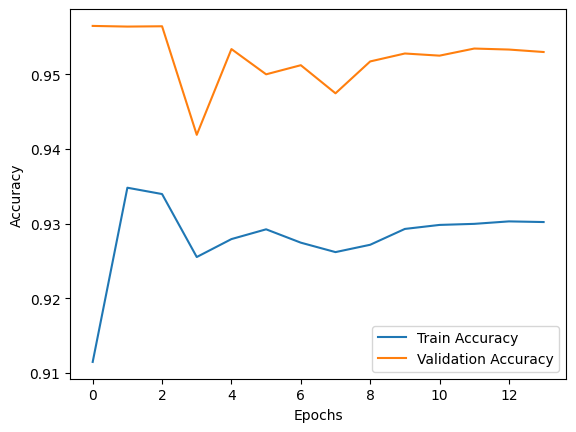

5322/5322 [==============================] - 4s 724us/step - loss: 4.9138e-05 - accuracy: 0.9517
Test Loss: 0.0000
Test Accuracy: 95.17%
5322/5322 [==============================] - 3s 642us/step


In [48]:
# Define callbacks
callbacks = [
    ModelCheckpoint(filepath='autoencoder_model.keras', save_best_only=True),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
]

# Compile the model with the appropriate metrics
autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

# Train the autoencoder
history = autoencoder.fit(Xn_train, Xn_train, epochs=20, batch_size=128, 
                          validation_data=(X_test, X_test), 
                          callbacks=callbacks, verbose=1)

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluate the model on the test set
loss, accuracy = autoencoder.evaluate(X_test, X_test)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy * 100:.2f}%')

# Use the trained autoencoder for prediction
encoded_data = encoder.predict(X_test)
decoded_data = decoder.predict(encoded_data)

5322/5322 [==============================] - 4s 776us/step


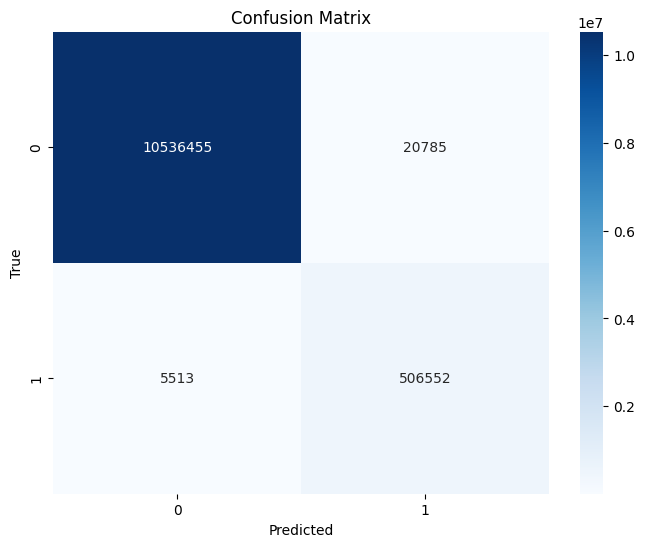


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00  10557240
           1       0.96      0.99      0.97    512065

    accuracy                           1.00  11069305
   macro avg       0.98      0.99      0.99  11069305
weighted avg       1.00      1.00      1.00  11069305



In [49]:
# Function to convert probabilities to binary predictions
def convert_to_binary(predictions, threshold=0.5):
    return (predictions > threshold).astype(int)

# Make predictions on the test set
decoded_test = autoencoder.predict(X_test)

# Convert predictions to binary
decoded_test_binary = convert_to_binary(decoded_test)

# Convert true labels to binary
y_test_binary = convert_to_binary(X_test)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test_binary.flatten(), decoded_test_binary.flatten())

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Print the classification report
print("\nClassification Report:")
print(classification_report(y_test_binary.flatten(), decoded_test_binary.flatten()))